## 이미지분석_사진유사도비교_mediapipe_deepface
* https://ai.google.dev/edge/mediapipe/solutions/vision/face_detector/python?hl=ko

In [1]:
# 이미지 유사도 분석 모델 다운로드
!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

In [1]:
import urllib
import cv2
import math
import matplotlib.pyplot as plt

In [4]:
image_file_names = ['burger.jpg', 'burger_crop.jpg']

for name in image_file_names:
    url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
    urllib.request.urlretrieve(url, name)

In [5]:
desired_height = 480
desired_width = 480

In [6]:
def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (desired_width, math.floor(h/(w/desired_width))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/desired_height)), desired_height))
        
    return img

burger.jpg


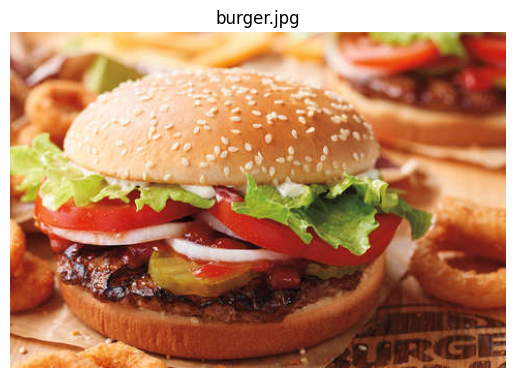

burger_crop.jpg


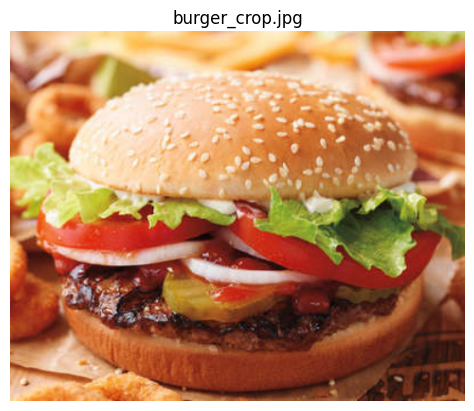

In [7]:
# 이미지 미리보기
images = {name: cv2.imread(name) for name in image_file_names}
for name, image in images.items():
    print(name)
    resized_image = resize_and_show(image)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('off')
    plt.show()

## mediapipe model 불러와서 유사도 분석

In [2]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

2025-05-21 13:02:39.517558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 13:02:40.178000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747800160.452168     474 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747800160.526321     474 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747800161.070877     474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [9]:
base_options = python.BaseOptions(model_asset_path='./data/embedder.tflite')
l2_normalize = True
quantize = True
options = vision.ImageEmbedderOptions(
        base_options=base_options, l2_normalize=l2_normalize, quantize=quantize
        )

# create image embedder
with vision.ImageEmbedder.create_from_options(options) as embedder:
    first_image = mp.Image.create_from_file(image_file_names[0])
    second_image = mp.Image.create_from_file(image_file_names[1])
    first_embedding_result = embedder.embed(first_image)
    second_embedding_result = embedder.embed(second_image)
    
    # 유사도 비교(코사인 유사도 사용)
    similarity = vision.ImageEmbedder.cosine_similarity(
                first_embedding_result.embeddings[0],
                second_embedding_result.embeddings[0]
    )
    print(similarity)

I0000 00:00:1747793141.555144     740 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1747793141.587662    1381 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: D3D12 (NVIDIA GeForce MX450)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


RuntimeError: Image decoding failed (can't fopen): burger.jpg

## mediapipe model로 얼굴 유사도 판별하기
* 사진 2장 필요
* 사진에서 얼굴 찾기 - 얼굴 찾는 모델
* 얼굴만 크롭
* 얼굴을 숫자로 임베딩 - 이미지를 숫자로 벡터화(임베딩)
* 임베딩 된 얼굴을 비교
* 유사도 출력
* 간단한 서비스 구현을 위해 gradio 라이브러리 활용
* https://www.gradio.app/playground

In [11]:
# !pip install gradio

In [3]:
import gradio as gr
import numpy as np

/home/ceun2/miniforge3/envs/face/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 사진에서 얼굴 추출하는 함수 작성

In [4]:
def crop_face(image_np):
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
        results = detector.process(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
        if not results.detections:
            return None
        bbox = results.detections[0].location_data.relative_bounding_box
        h, w, _ = image_np.shape
        x_min = int(bbox.xmin * w)
        y_min = int(bbox.ymin * h)
        width = int(bbox.width * w)
        height = int(bbox.height * h)
        return image_np[y_min:y_min+height, x_min:x_min+width]

# 얼굴 유사도 비교 함수 작성

In [5]:
def image_to_text(image1, image2):
    # 이미지 없는 경우 예외처리
    if image1 is None or image2 is None:
        return '이미지를 두 장 모두 업로드하세요.'
    
    img1 = cv2.cvtColor(np.array(image1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(np.array(image2), cv2.COLOR_BGR2RGB)
    
    # crop_face 함수로 얼굴만 추출해서 저장
    face1 = crop_face(img1)
    face2 = crop_face(img2)
    
    if face1 is None or face2 is None:
        return '얼굴 감지 실패'
    
    cv2.imwrite('face1.jpg',face1)
    cv2.imwrite('face2.jpg',face2)
    
    base_options = python.BaseOptions(model_asset_path='./data/embedder.tflite')
    options = vision.ImageEmbedderOptions(
            base_options=base_options, l2_normalize=True, quantize=True
            )

    # create image embedder
    with vision.ImageEmbedder.create_from_options(options) as embedder:
        face1_mp = mp.Image.create_from_file('face1.jpg')
        face2_mp = mp.Image.create_from_file('face2.jpg')
        emb1 = embedder.embed(face1_mp).embeddings[0]
        emb2 = embedder.embed(face2_mp).embeddings[0]

        # 유사도 비교(코사인 유사도 사용)
        similarity = vision.ImageEmbedder.cosine_similarity(
                    emb1,
                    emb2
        )
        return f'얼굴 유사도 : {similarity:.4f}'

# gradio를 이용해서 UI 및 간이 서버 만들기
* 내부적으로 fastapi 프레임워크 사용 : 웹서버

In [6]:
with gr.Blocks() as app:
    gr.Markdown('얼굴 유사도 비교')
    
    with gr.Tab('Image Upload'):
        with gr.Column():
            image1 = gr.Image(label='First Image')
        with gr.Column():
            image2 = gr.Image(label='Second Image')
    output = gr.Textbox(label='얼굴 유사도 :')
    convert_btn = gr.Button('유사도 비교하기')
    convert_btn.click(
        fn=image_to_text, inputs=[image1, image2], outputs=output)
    
app.launch(inline=False, share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://112ed415d6babc0d42.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Deepface
* https://pypi.org/project/deepface/
* 정확도 높은 얼굴인식 프로그램 만들기

In [8]:
# !pip install deepface
# !pip install tf-keras

In [9]:
import gradio as gr
from deepface import DeepFace
import cv2
import numpy as np

25-05-21 13:09:19 - Directory /home/ceun2/.deepface has been created
25-05-21 13:09:19 - Directory /home/ceun2/.deepface/weights has been created


### 유사도 %로 표시하는 함수

In [19]:
def convert_distance_to_similarity(distance, threshold, verified):
    if verified:
        # 일치할 경우
        ratio = max(0, 1-(distance/threshold))
        return round(90 + ratio * 10, 2)
    else:
        # 불일치할 경우
        ratio = max(0, 1 - (distance/(threshold*2)))
        return round(ratio * 60, 2)

## 얼굴 유사도 비교 함수 (ArcFace)

In [20]:
def image_to_text(image1, image2):
    if image1 is None or image2 is None:
        return '두 이미지 모두 업로드 해주세요.'
    image1 = cv2.cvtColor(np.array(image1), cv2.COLOR_RGB2BGR)
    image2 = cv2.cvtColor(np.array(image2), cv2.COLOR_RGB2BGR)
    cv2.imwrite('image1.jpg',image1)
    cv2.imwrite('image2.jpg',image2)
    
    try:
        threshold = 0.68 # ArcFace 기준으로 두 이미지가 일치하는 기준
        result = DeepFace.verify('image1.jpg', 'image2.jpg', model_name='SFace')
        distance = result['distance']
        verified = result['verified']
        similarity_score = convert_distance_to_similarity(distance, threshold, verified)
        result_text = f'ArcFace 기준 얼굴 유사도 분석 :\n{similarity_score:.2f}%\n \
        얼굴 일치 여부 : {"일치" if verified else "불일치"}'
        return result_text
    except Exception as e:
        return f'오류 : {str(e)}'

## gradio로 입출력 인터페이스 만들기

In [21]:
with gr.Blocks() as app:
    gr.Markdown('얼굴 유사도 비교 (ArcFace 기반)')
    with gr.Tab('이미지 업로드'):
        with gr.Row():
            with gr.Column():
                image1 = gr.Image(label='첫번째 얼굴')
            with gr.Column():
                image2 = gr.Image(label='두번째 얼굴')
        output = gr.Textbox(label='분석 결과')
        compare_btn = gr.Button('유사도 비교')
        compare_btn.click(fn=image_to_text, inputs=[image1, image2], outputs=output)

app.launch(inline=False, share=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://01dc16f8ba57632781.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 여러 모델과 유사도 측정 측도 변경하면서 비교하기

In [22]:
import gradio as gr
from deepface import DeepFace
import cv2

In [23]:
# 정확도 기준으로 정렬된 모델 목록
models = [
    'ArcFace',      # 99.83%
    'SFace',        # ~99.5%  
    'Facenet512',   # 99.20%
    'Facenet',      # 99%
    'GhostFaceNet', # ~98.8%
    'VGG-Face',     # 98.78%
    'OpenFace',     # 93.60%
    'DeepID'        # 89%
]

In [24]:
# 모델별 거리 측도
recommended_metric = {
    'ArcFace' : 'cosine',      # 99.83%
    'SFace' : 'cosine',        # ~99.5%  
    'Facenet512' : 'euclidean_l2',   # 99.20%
    'Facenet' : 'euclidean_l2',      # 99%
    'GhostFaceNet' : 'cosine', # ~98.8%
    'VGG-Face' : 'euclidean',     # 98.78%
    'OpenFace' : 'euclidean_l2',     # 93.60%
    'DeepID' : 'euclidean'        # 89%
}

In [26]:
# 모델별 threshold
model_thresholds = {
    'ArcFace' : 0.68,      # 99.83%
    'SFace' : 0.593,        # ~99.5%  
    'Facenet512' : 0.3,   # 99.20%
    'Facenet' : 0.4,      # 99%
    'GhostFaceNet' : 0.25, # ~98.8%
    'VGG-Face' : 0.4,     # 98.78%
    'OpenFace' : 0.55,     # 93.60%
    'DeepID' : 0.17        # 89%
}

### 유사도 %로 표시하는 함수

In [19]:
def convert_distance_to_similarity(distance, threshold, verified):
    if verified:
        # 일치할 경우
        ratio = max(0, 1-(distance/threshold))
        return round(90 + ratio * 10, 2)
    else:
        # 불일치할 경우
        ratio = max(0, 1 - (distance/(threshold*2)))
        return round(ratio * 60, 2)

## 얼굴 유사도 비교 함수 (ArcFace)

In [30]:
def image_to_text(image1, image2, model):
    if image1 is None or image2 is None:
        return '두 이미지 모두 업로드 해주세요.'
    
    # 추천 metric 및 threshold 불러오기
    metric = recommended_metric.get(model, 'cosine')
    threshold = model_thresholds.get(model, '0.5')
    
    cv2.imwrite('image1.jpg',image1)
    cv2.imwrite('image2.jpg',image2)
    
    try:
        result = DeepFace.verify('image1.jpg', 'image2.jpg', model_name=model,
                                 distance_metric=metric,
                                 enforce_detection=True)
        distance = result['distance']
        verified = result['verified']
        similarity_score = convert_distance_to_similarity(distance, threshold, verified)
        result_text = f'{model} 기준 얼굴 유사도 분석 :\n{similarity_score:.2f}%\n얼굴 일치 여부 : {"일치" if verified else "불일치"}'
        return result_text
    except Exception as e:
        return f'오류 : {str(e)}'

## gradio로 입출력 인터페이스 만들기

In [34]:
with gr.Blocks() as app:
    gr.Markdown('얼굴 유사도 비교')
    with gr.Tab('이미지 업로드'):
        with gr.Row():
            with gr.Column():
                image1 = gr.Image(label='첫번째 얼굴')
            with gr.Column():
                image2 = gr.Image(label='두번째 얼굴')
        model = gr.Dropdown(label='model', choices=models, value='ArcFace')
        output = gr.Textbox(label='분석 결과')
        compare_btn = gr.Button('유사도 비교')
        compare_btn.click(fn=image_to_text, inputs=[image1, image2, model], outputs=output)

app.launch(inline=False, share=True)

* Running on local URL:  http://127.0.0.1:7867
* Running on public URL: https://82e956e33a7d228685.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


25-05-21 14:26:08 - deepid_keras_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/deepid_keras_weights.h5
To: /home/ceun2/.deepface/weights/deepid_keras_weights.h5
100%|███████████████████████████████| 1.61M/1.61M [00:00<00:00, 22.5MB/s]
I0000 00:00:1747805169.873337     840 cuda_dnn.cc:529] Loaded cuDNN version 90300


25-05-21 14:26:19 - openface_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/openface_weights.h5
To: /home/ceun2/.deepface/weights/openface_weights.h5
100%|███████████████████████████████| 15.3M/15.3M [00:00<00:00, 38.6MB/s]


25-05-21 14:26:42 - facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /home/ceun2/.deepface/weights/facenet512_weights.h5
100%|███████████████████████████████| 95.0M/95.0M [00:01<00:00, 47.8MB/s]
2025-05-21 14:26:48.910120: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


In [35]:
gr.close_all()